In [1]:
import numpy as np
import matplotlib.pyplot as plt

import stim_util as fn
from neuron import MHH, AdExpIF
from simulation import Simulation

# Figures

### Create a simulation environment

In [2]:
mySim = Simulation(period=1500, fs=100)

### Create a stimulation signal

In [3]:
I_stim = 2 #* 20.5
    
I = I_stim * np.ones(mySim.t.shape)  # pA

slope = fn.gen_slope(init_time=0, end_time=200, time_points=mySim.t)

# Sinusoid
I1 = fn.gen_sin(init_time=0, freq=.010, phase=0, time_points=mySim.t)
# I2 = fn.gen_sin(init_time=50, freq=.01, phase=0, time_points=Sim_t)

# I = slope * (I_stim * (I3 * .1 + I2 * 1) + 0)
I = slope * I_stim * I1

# sinusoid + chirp
I1 = fn.gen_sin(init_time=0, freq=1, phase=0, time_points=mySim.t)
I2 = fn.gen_sin(init_time=0, freq=1.01, phase=0, time_points=mySim.t)

I3, freq = fn.gen_chirp(init_freq=1.001, init_time=0, end_freq=1.02, end_time=mySim.t[-1], time_points=mySim.t)

# freq *= 1000  # change from kHz to Hz
# I = slope * (I_stim * (.5*I1 + .5*I2))

# Chirp stimulation
# out, freq = fn.gen_chirp(init_freq=.0001, init_time=0, end_freq=.02, end_time=mySim.t[-1], time_points=mySim.t)

# I      = I_stim * out  # pA

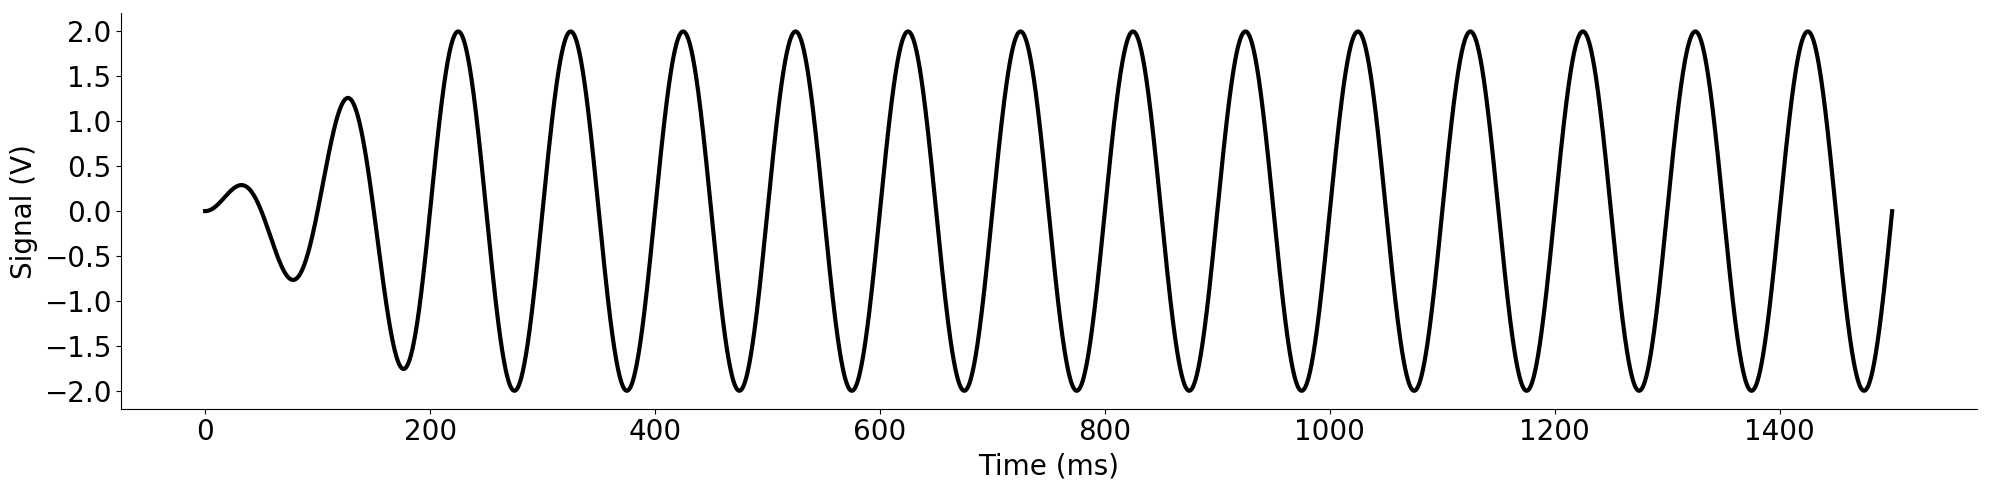

In [5]:
fig, ax = plt.subplots(figsize=(20,5), dpi=100)
ax.plot(mySim.t, I, c='k', linewidth=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Signal (V)', fontsize=20)
plt.tight_layout()

---

### MHH neuron model

In [6]:
const_params = {
    # variable = value xxx Unit
    'gNA': 240, # m.mho/cm^2
    'gK': 36, # m.mho/cm^2
    'gA': 61, # m.mho/cm^2
    'gL': 0.068, # m.mho/cm^2
    'ENA': 64.7, # mV
    'EK': -95.2, # mV
    'EL': -51.3, # mV
    'C': 1, # uF/cm^2
    'Er': -71,
    'g_L': 10000,
    'L': 1
}

In [7]:
# Na channel: m, h
# delayed-rectifier K current: n
# slow non-inactivating K current: p, a, 
tracked_params = ['m', 'h', 'n', 'p', 'a', 'b', 
                  'u', 'b', 'INA', 'IK', 'IA', 'I_L']

In [8]:
myNeuron = MHH(const_params=const_params,
               tracked_params=tracked_params,
               time_points=mySim.t)

### Run the simulation

In [9]:
mySim.neuron = myNeuron
mySim.stim = I

mySim.run()

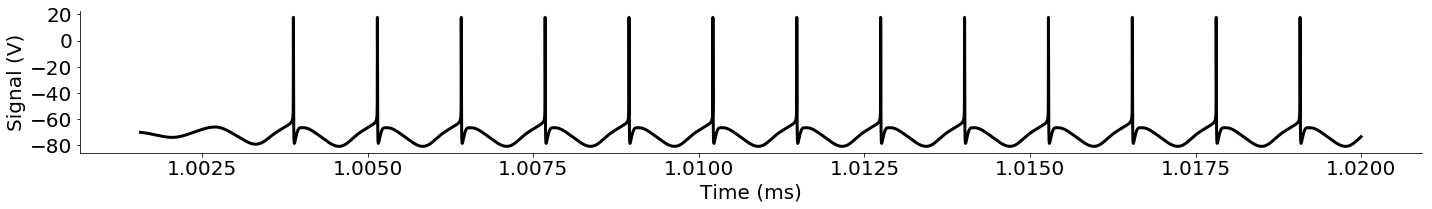

In [10]:
fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(freq[4500:], myNeuron.u[4500:], c='k', linewidth=3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Signal (V)', fontsize=20)
plt.tight_layout()

---

**Note: All the input currents for MHH model are in pA (pico ampere)**

#### Figure 3C: MHH response to ZAP input

In [11]:
# Chirp stimulation
I, freq = fn.gen_chirp(init_freq=.0001, init_time=0, end_freq=.02, end_time=mySim.t[-1], time_points=mySim.t)

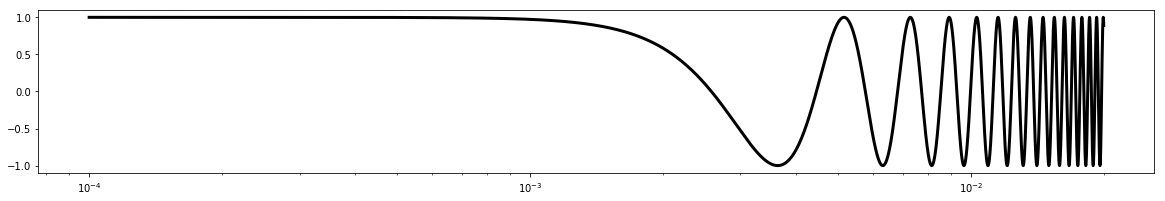

In [14]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(freq, I, c='k', linewidth=3)
plt.xscale('log')

In [40]:
mySim.stim = I * 2
mySim.run()

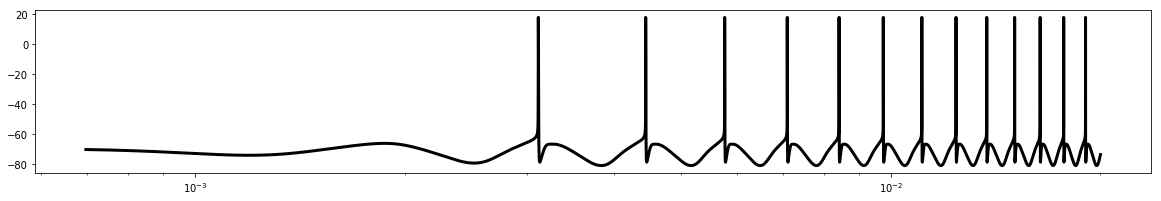

In [15]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(freq[4500:], myNeuron.u[4500:], c='k', linewidth=3)
plt.xscale('log')

---

#### Figure 3D: MHH neuron response to AMZAP

In [17]:
I1 = fn.gen_sin(init_time=0, freq=1.0, phase=0, time_points=mySim.t)
I2, freq = fn.gen_chirp(init_freq=1.001,  init_time=0, end_freq=1.02, end_time=mySim.t[-1], time_points=mySim.t)
I = .5*I1 + .5*I2

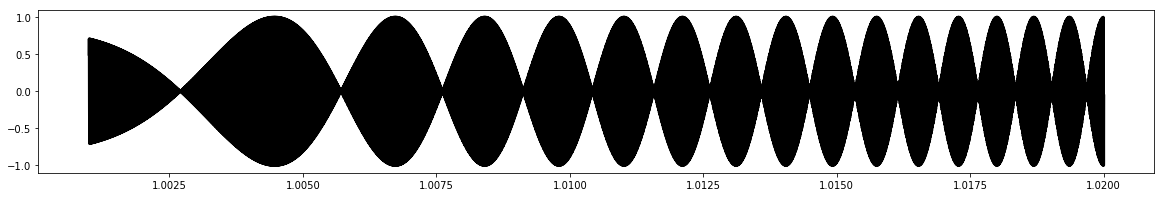

In [21]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(freq, I, c='k', linewidth=3)
# plt.xscale('log')

In [22]:
mySim.stim = I
mySim.run()

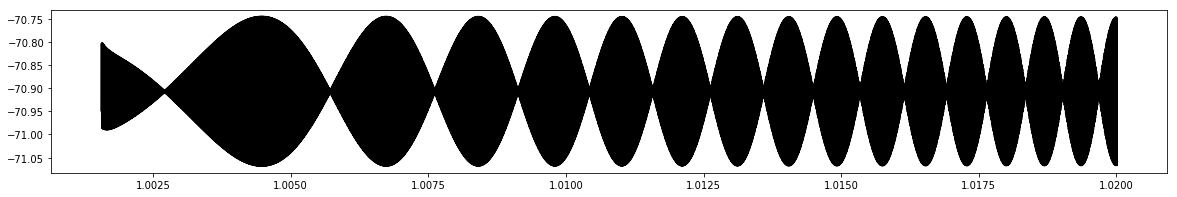

In [23]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(freq[4500:], myNeuron.u[4500:], c='k', linewidth=3)
plt.show()

---

#### MHH neuron response to TI stimulation at the superficial regions

In [46]:
I1 = fn.gen_sin(init_time=0, freq=1.0, phase=0, time_points=mySim.t)
I2 = fn.gen_sin(init_time=0, freq=1.01, phase=0, time_points=mySim.t)
I = I1 + I2

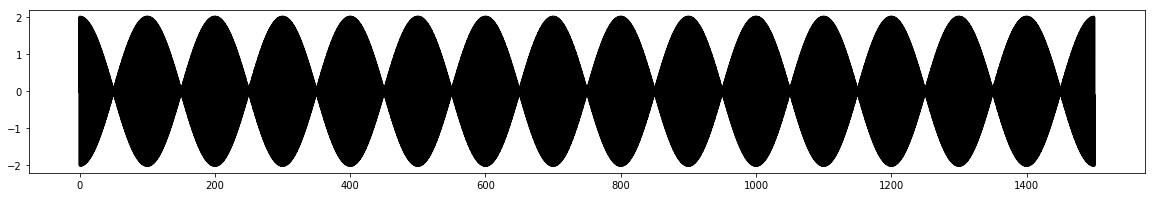

In [47]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(mySim.t, I, c='k', linewidth=3)

In [49]:
mySim.stim = I
mySim.run()

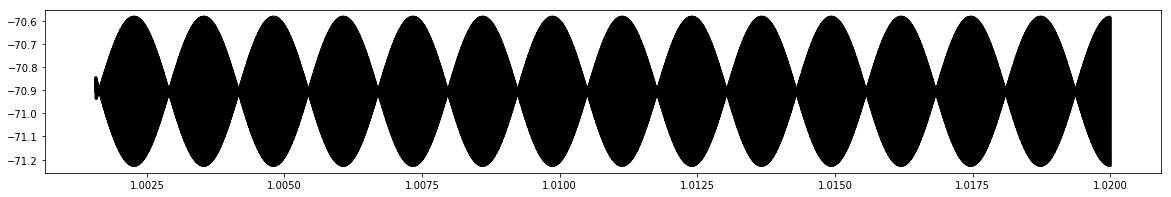

In [50]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(freq[4500:], myNeuron.u[4500:], c='k', linewidth=3)
plt.show()

---

#### MHH neuron response to TI stimulation at depth

In [52]:
I1 = fn.gen_sin(init_time=0, freq=1.0, phase=0, time_points=mySim.t)
I2 = fn.gen_sin(init_time=0, freq=1.01, phase=0, time_points=mySim.t)
I = I1 + I2

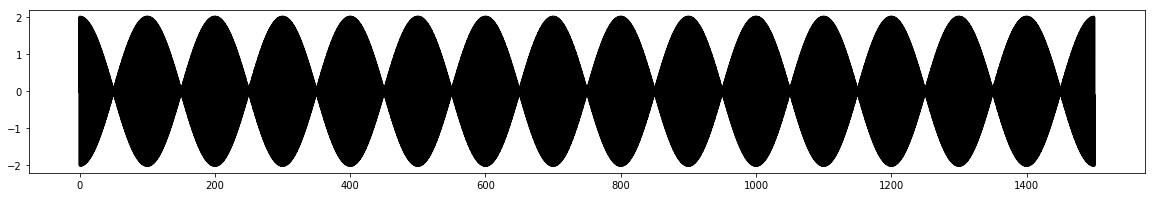

In [53]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(mySim.t, I, c='k', linewidth=3)

In [54]:
mySim.stim = I
mySim.run()

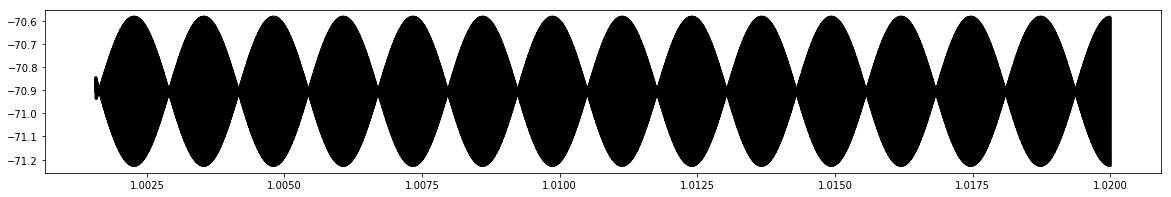

In [55]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(freq[4500:], myNeuron.u[4500:], c='k', linewidth=3)
plt.show()

---

#### MHH neuron response to direct 10 Hz stimulation

In [56]:
I = fn.gen_sin(init_time=0, freq=.01, phase=0, time_points=mySim.t)

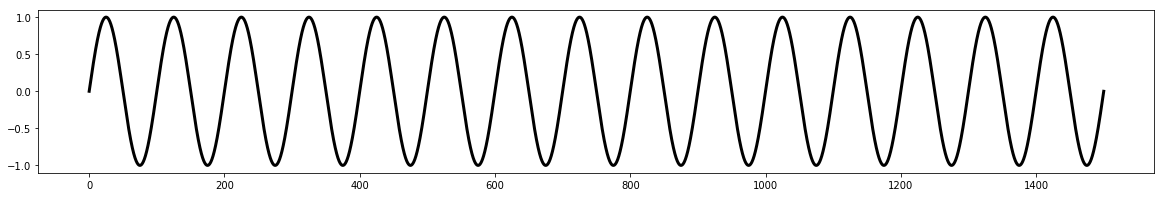

In [57]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(mySim.t, I, c='k', linewidth=3)

In [58]:
mySim.stim = I
mySim.run()

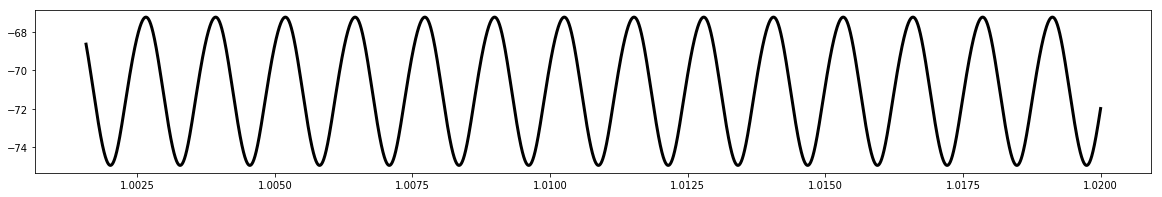

In [59]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(freq[4500:], myNeuron.u[4500:], c='k', linewidth=3)
plt.show()

---

#### MHH neuron response to AM 10 Hz stimulation

In [60]:
I1 = fn.gen_sin(init_time=0, freq=1.0, phase=0, time_points=mySim.t)
I2 = fn.gen_sin(init_time=0, freq=1.01, phase=0, time_points=mySim.t)
I = I1 + I2

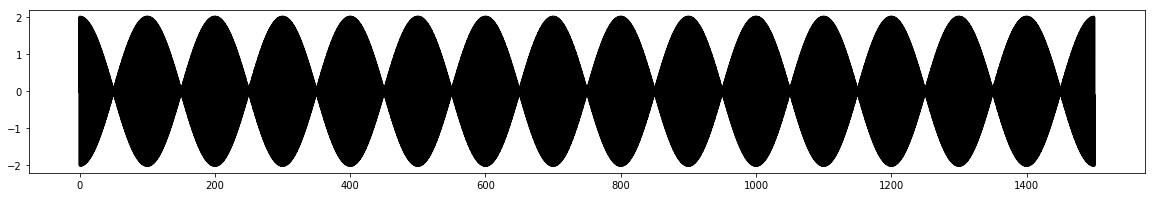

In [61]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(mySim.t, I, c='k', linewidth=3)

In [62]:
mySim.stim = I
mySim.run()

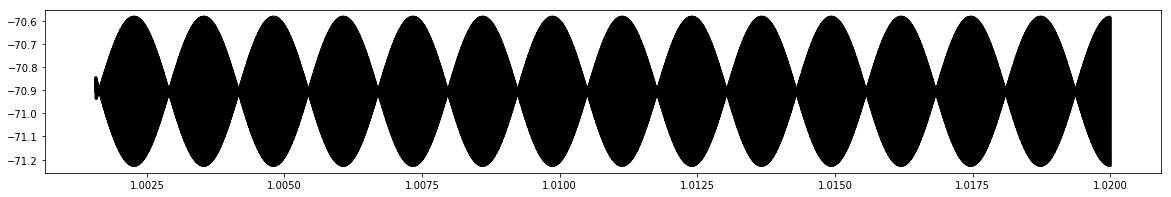

In [63]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(freq[4500:], myNeuron.u[4500:], c='k', linewidth=3)
plt.show()

---

### Adaptive Exponential Integrate and Fire (AdExpIF) neuron model

In [64]:
const_params = {
    'C': 130,  # pF - membrane capacitance
    'gL': 1,  # nS - leak conductance
    'EL': -70.6,  # mV
    'VT': -50.6,  # mV
    'dT': 2,  # mV
    'tauw': 300,  # ms adaptation time-constant
    'a': 30,  # mS - subthreshold oscillation parameter
    'b': 80.5,  # pA - spike-triggered adaptation constants
    'vpeak': 20,  # mV
    'taum': 130/1  # C/gL
}

tracked_params = ['v', 'w']

In [65]:
myNeuron = AdExpIF(const_params=const_params,
                   tracked_params=tracked_params,
                   time_points=mySim.t)

In [66]:
I_stim = 80 * 270
slope = fn.gen_slope(init_time=0, end_time=200, time_points=mySim.t)
I1 = fn.gen_sin(freq=1.005, time_points=mySim.t)
I2 = fn.gen_sin(freq=1, time_points=mySim.t)
I = slope * I_stim * (.5*I1 + .5*I2)

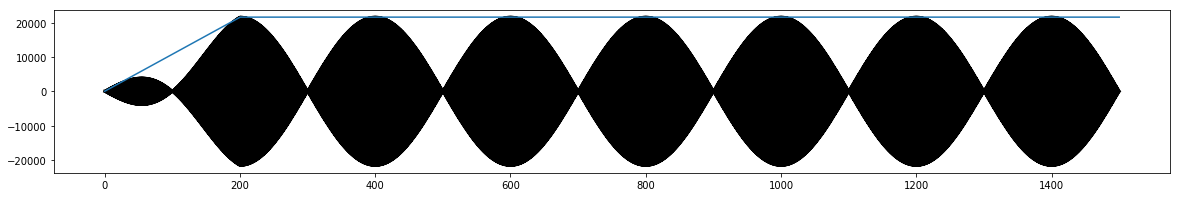

In [67]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(mySim.t, I, c='k', linewidth=3)
ax.plot(mySim.t, slope * np.max(I))
plt.show()

In [68]:
mySim.stim = I
mySim.neuron = myNeuron

mySim.run()

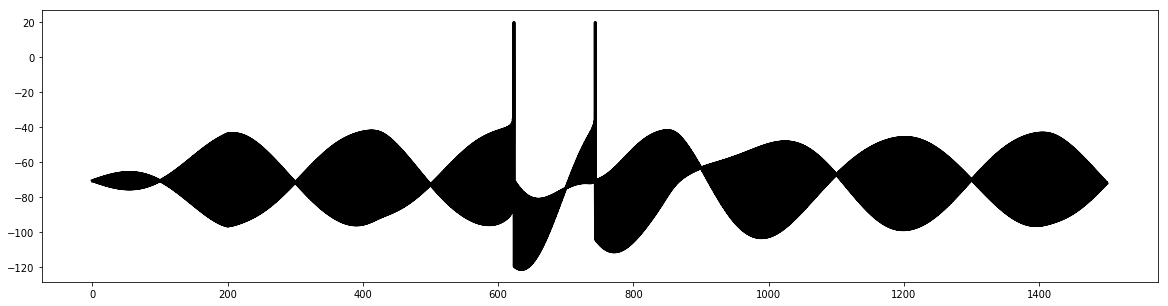

In [69]:
plt.figure(figsize=(20,5))
plt.plot(mySim.t, myNeuron.v, c='k', linewidth=3)
plt.show()